# Machine Learning in MusicBox

While MusicBox does not support machine learning directly, it is possible to feed in the model's output to a learner to create a generalized machine learning (ML) model.</br>
Machine learning involves the development of statistical algorithms that learn from existing data so that the model can be generalized to new data.</br>
This tutorial will go through a very basic example of running a simulation with the data being passed into a linear regression model as well as a random forest model.</br>
These models will attempt to predict some of the time steps of the simulation given a subset of the dataset not including the predicted time steps to prevent overfitting.</br>
Do note that both of the models that will be created are toy models and do not represent real-life situtations.

## 1. Importing Libraries

Below is a list of the required libraries for this tutorial:

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from acom_music_box import MusicBox, Conditions
import musica.mechanism_configuration as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 2. Setting up and Solving the System

This code cell is a copy of the setup from the [Basic Workflow Tutorial](1.%20basic_workflow.ipynb), but with the evolving condition removed and the A parameter for the first reaction increased by a magnitude of 100 to induce a non-linear reaction.

In [2]:
# Create each of the species that will be simulated
X = mc.Species(name="X")
Y = mc.Species(name="Y")
Z = mc.Species(name="Z")
species = {"X": X, "Y": Y, "Z": Z}
gas = mc.Phase(name="gas", species=list(species.values()))
# Create the reactions that the species undergo in the
arr1 = mc.Arrhenius(name="X->Y", A=4.0e-1, C=50, reactants=[species["X"]], products=[species["Y"]], gas_phase=gas)
arr2 = mc.Arrhenius(name="Y->Z", A=4.0e-3, C=50, reactants=[species["Y"]], products=[species["Z"]], gas_phase=gas)
rxns = {"X->Y": arr1, "Y->Z": arr2}
# Create the mechanism that is defined by the species, phases, and reactions
mechanism = mc.Mechanism(name="tutorial_mechanism", species=list(species.values()), phases=[gas], reactions=list(rxns.values()))
# Create the box model that contains the mechanism
box_model = MusicBox()
box_model.load_mechanism(mechanism)
# Set the conditions of the box model at time = 0 s
box_model.initial_conditions = Conditions(
    temperature=298.15, # Units: Kelvin (K)
    pressure=101325.0, # Units: Pascals (Pa)
    species_concentrations={ # Units: mol/m^3
        "X": 3.75,
        "Y": 5.0,
        "Z": 2.5,
    }
)
# Set the additional configuration options for the box model
box_model.box_model_options.simulation_length = 199 # Units: Seconds (s)
box_model.box_model_options.chem_step_time = 1 # Units: Seconds (s)
box_model.box_model_options.output_step_time = 1 # Units: Seconds (s)

df = box_model.solve()

display(df)

,time.s,ENV.temperature.K,ENV.pressure.Pa,ENV.air number density.mol m-3,CONC.X.mol m-3,CONC.Y.mol m-3,CONC.Z.mol m-3
0,0.0,298.15,101325.0,40.874045,3.750000e+00,5.000000,2.500000
1,1.0,298.15,101325.0,40.874045,2.336557e+00,6.386248,2.527194
2,2.0,298.15,101325.0,40.874045,1.455834e+00,7.234592,2.559574
3,3.0,298.15,101325.0,40.874045,9.070407e-01,7.747848,2.595111
4,4.0,298.15,101325.0,40.874045,5.650710e-01,8.052385,2.632544
...,...,...,...,...,...,...,...
195,195.0,298.15,101325.0,40.874045,3.129731e-40,3.493691,7.756309
196,196.0,298.15,101325.0,40.874045,1.949733e-40,3.477204,7.772796
197,197.0,298.15,101325.0,40.874045,1.214628e-40,3.460794,7.789206
198,198.0,298.15,101325.0,40.874045,7.566784e-41,3.444462,7.805538


## 3. Creating the Future Time Steps

In order to build the ML model, it needs an expected output for every input for each of the species' concentrations.</br>
To achieve this, three new columns are made to represent the reaction one time step ahead of the current time step.</br>
When the model is constructed, it will attempt to predict the values one time step ahead from the values at the current time step.</br>
However, you can increase the number of time steps you wish to predict ahead by changing the <i>t_steps_ahead</i> to be a larger number.</br>
For example, a <i>t_steps_ahead</i> of 5 means the model will predict the concentrations five time steps ahead for every step.</br>
There is a fourth column also added called <i>dt</i>, which simply represents the time step length which will be fed into the model as an independent variable.</br>
Lastly, since the model is trying to predict the future, there will be time steps at the end where there will be no future concentrations since the simulation ended, thus leading to a NaN value.</br>
These rows at the end are all dropped to prevent these incomplete rows from being added to the model.

In [3]:
t_steps_ahead = 1

df['CONC.X.mol m-3 t+1'] = df['CONC.X.mol m-3'].shift(-t_steps_ahead)
df['CONC.Y.mol m-3 t+1'] = df['CONC.Y.mol m-3'].shift(-t_steps_ahead)
df['CONC.Z.mol m-3 t+1'] = df['CONC.Z.mol m-3'].shift(-t_steps_ahead)

# 'dt' represents the time step length, repeat for every time step plus the original t=0 time step
df['dt'] = np.repeat(box_model.box_model_options.output_step_time, box_model.box_model_options.simulation_length + 1)

df = df.drop(df.index[-t_steps_ahead:])

## 4. Defining the Independent and Dependent Variables

Next, the independent and dependent variables must be defined.</br>
For any ML model, your independent variables will be predicting the dependent variables</br>
For this model, the indepedent variables are:
* the temperature,
* the pressure,
* the time step length discussed in the previous step, and
* the three species' concentrations.

The dependent variables are each of the species' concentrations at the desired future time step (by default one time step into the future).

In [4]:
x = df[['ENV.temperature.K', 'ENV.pressure.Pa', 'dt', 'CONC.X.mol m-3', 'CONC.Y.mol m-3', 'CONC.Z.mol m-3']]
y = df[['CONC.X.mol m-3 t+1', 'CONC.Y.mol m-3 t+1', 'CONC.Z.mol m-3 t+1']]

## 5. Making the Train-Test Split for the Data

Once the independent and dependent variables are defined, they can each be split into training and testing data.</br>
Training data refers to the data that is fed into the model in order to fit it.</br>
For linear regression, this fit will be an equation of the form yx + b, where y represents the slope and b represents the y-intercept.</br>
On the other hand, the testing data is data that the model is blind to and will attempt to predict after being shown the training data.</br>
For this model, 80% of the data will be for training, and 20% will be for testing.</br>
Once the data is split, it is all sorted by index in order to make plotting the results much simpler; it does not affect the model.

In [5]:
# Split data into train/test (80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

x_train = x_train.sort_index()
x_test = x_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()

## 6. Normalizing the Concentrations

For many ML models, including linear regression, normalizing your data will ensure that each of the input and output features are weighted equally when they are not on the same scale initially.</br>
This is the case for the concentrations, where X drops all the way to 4e-41 while Y never goes below 3.4, a ginormous difference in scale.</br>
To normalize the data, two <i>MinMaxScaler()</i> objects are created, one for the dependent dependent concentration variables, and one for the independent concentration variables.</br>
These scalers can be fitted and alter the training data concentration columns in place with its <i>fit_transform()</i> function by taking in a column that is used to calcuate the normalized values.</br>
However, the testing data is scaled with the <i>transform()</i> function since you never want to fit on your testing data, as it will lead to data leakages, causing the model to overfit.
It should be noted that the t+1 columns are normalized based on the original concentration columns so that the normalization is kept consistent between the original column and the future time step column.</br>
The four scaled DataFrames are then displayed so that you can see what the normalization does to the concentration values.

In [6]:
x_scaler = MinMaxScaler()
sub_xtrain = x_train[['CONC.X.mol m-3', 'CONC.Y.mol m-3','CONC.Z.mol m-3']]
temp_pressure = x_train[['ENV.temperature.K','ENV.pressure.Pa','dt']]
x_train_scaled = x_scaler.fit_transform(sub_xtrain)

x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=sub_xtrain.columns, index=sub_xtrain.index)
x_train_scaled_df = pd.concat([temp_pressure,x_train_scaled_df],axis=1)
display(x_train_scaled_df)

sub_xtest = x_test[['CONC.X.mol m-3', 'CONC.Y.mol m-3','CONC.Z.mol m-3']]
temp_pressure = x_test[['ENV.temperature.K','ENV.pressure.Pa','dt']]
x_test_scaled = x_scaler.transform(sub_xtest)

x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=sub_xtest.columns, index=sub_xtest.index)
x_test_scaled_df = pd.concat([temp_pressure,x_test_scaled_df],axis=1)
display(x_test_scaled_df)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(sub_xtrain)
y_train_scaled_df = pd.DataFrame(y_train_scaled, columns=y_train.columns, index=y_train.index)
display(y_train_scaled_df)

y_test_scaled = y_scaler.transform(sub_xtest)
y_test_scaled_df = pd.DataFrame(y_test_scaled, columns=y_test.columns, index=y_test.index)
display(y_test_scaled_df)

,ENV.temperature.K,ENV.pressure.Pa,dt,CONC.X.mol m-3,CONC.Y.mol m-3,CONC.Z.mol m-3
0,298.15,101325.0,1,1.000000e+00,0.315454,0.000000
1,298.15,101325.0,1,6.230820e-01,0.596577,0.005126
2,298.15,101325.0,1,3.882224e-01,0.768617,0.011229
3,298.15,101325.0,1,2.418775e-01,0.872702,0.017927
4,298.15,101325.0,1,1.506856e-01,0.934460,0.024982
...,...,...,...,...,...,...
192,298.15,101325.0,1,3.250225e-40,0.020109,0.981310
194,298.15,101325.0,1,1.137920e-40,0.013343,0.987599
196,298.15,101325.0,1,3.181479e-41,0.006640,0.993829
197,298.15,101325.0,1,1.221199e-41,0.003312,0.996922


,ENV.temperature.K,ENV.pressure.Pa,dt,CONC.X.mol m-3,CONC.Y.mol m-3,CONC.Z.mol m-3
7,298.15,101325.0,1,3.643141e-02,0.997585,0.047068
10,298.15,101325.0,1,8.808060e-03,0.994510,0.069450
15,298.15,101325.0,1,8.264578e-04,0.960910,0.106321
23,298.15,101325.0,1,1.874845e-05,0.899883,0.163612
24,298.15,101325.0,1,1.167975e-05,0.892346,0.170622
28,298.15,101325.0,1,1.759162e-06,0.862535,0.198336
41,298.15,101325.0,1,3.744474e-09,0.769432,0.284869
44,298.15,101325.0,1,9.053054e-10,0.748748,0.304094
46,298.15,101325.0,1,3.513430e-10,0.735120,0.316760
49,298.15,101325.0,1,8.494455e-11,0.714919,0.335535


,CONC.X.mol m-3 t+1,CONC.Y.mol m-3 t+1,CONC.Z.mol m-3 t+1
0,1.000000e+00,0.315454,0.000000
1,6.230820e-01,0.596577,0.005126
2,3.882224e-01,0.768617,0.011229
3,2.418775e-01,0.872702,0.017927
4,1.506856e-01,0.934460,0.024982
...,...,...,...
192,3.250225e-40,0.020109,0.981310
194,1.137920e-40,0.013343,0.987599
196,3.181479e-41,0.006640,0.993829
197,1.221199e-41,0.003312,0.996922


,CONC.X.mol m-3 t+1,CONC.Y.mol m-3 t+1,CONC.Z.mol m-3 t+1
7,3.643141e-02,0.997585,0.047068
10,8.808060e-03,0.994510,0.069450
15,8.264578e-04,0.960910,0.106321
23,1.874845e-05,0.899883,0.163612
24,1.167975e-05,0.892346,0.170622
28,1.759162e-06,0.862535,0.198336
41,3.744474e-09,0.769432,0.284869
44,9.053054e-10,0.748748,0.304094
46,3.513430e-10,0.735120,0.316760
49,8.494455e-11,0.714919,0.335535


## 7. Fitting, Predicting, and Evaluating the Model

With all the model preparation out of the way, it can now be created, fitted with the training data, and used to predict from the testing day.</br>
The with predicted y values calculated, the root mean square error (RMSE) and the correlation coefficient (R<sup>2</sup>) can be calculated.</br>
RMSE represents the average magnitude that a prediction is off.</br>
For example, a RMSE of 1 means the average concentration prediction is 1 mol/m<sup>3</sup> off from being correct.</br>
R<sup>2</sup> represents the percentage of variation in the dependent variables that is explained by the independent variables.</br>
For example, an R<sup>2</sup> of 0.5 means half of the variation in the dependent variables is explained by the independent variables.

In [7]:
# Train on training set
model = LinearRegression()
model.fit(x_train_scaled_df, y_train_scaled_df)

y_pred = model.predict(x_test_scaled_df)
test_mse = root_mean_squared_error(y_test_scaled_df, y_pred)
print(f"Test RMSE: {test_mse}")

r2 = r2_score(y_test_scaled_df, y_pred)
print(f"Coefficient of determination: {r2}")

Test RMSE: 2.642715325651818e-16
Coefficient of determination: 1.0


## 8. Preparing the Predicted Data for Visualization

In its current state, the <i>y_pred</i> array cannot be visualized properly due to indexing issues; it only represents 20% of the original dataset, so 80% of the indices are missing.</br>
Also, <i>y_pred</i> is normalized since it was fitted and predicted on normalized data, and it needs to be un-normalized so that it can be visualized with the correct scale.
To un-normalize the prediction array, simply take the <i>y_scaler</i> variable from step 6 and call its <i>inverse_transform()</i> function to undo the normalization.
Next, to fix the missing indices issue, the <i>y_pred</i> array is bundled into a DataFrame, taking the test indices as input initally.</br>
Then, the DataFrame is reindexed based on the original DataFrame's 200 indices. This will add back the missing indices with all NaN values, indicating that those time steps should not be plotted.</br>
The DataFrame is displayed before and after the reindexing so you can get an idea of what the <i>reindex()</i> function is doing.

In [8]:
y_pred = y_scaler.inverse_transform(y_pred)

conc_pred = pd.DataFrame(y_pred, index=y_test.index.tolist(), columns=['Predicted CONC.X.mol m-3', 'Predicted CONC.Y.mol m-3', 'Predicted CONC.Z.mol m-3'])
display(conc_pred)

conc_pred = conc_pred.reindex(df.index)
display(conc_pred)

,Predicted CONC.X.mol m-3,Predicted CONC.Y.mol m-3,Predicted CONC.Z.mol m-3
7,1.366178e-01,8.363659,2.749723
10,3.303022e-02,8.348498,2.868472
15,3.099217e-03,8.182812,3.064088
23,7.030668e-05,7.881882,3.368047
24,4.379905e-05,7.844713,3.405243
28,6.596856e-06,7.697713,3.552281
41,1.404178e-08,7.238614,4.011386
44,3.394896e-09,7.136617,4.113383
46,1.317537e-09,7.069418,4.180582
49,3.185431e-10,6.969804,4.280196


,Predicted CONC.X.mol m-3,Predicted CONC.Y.mol m-3,Predicted CONC.Z.mol m-3
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
194,NaN,NaN,NaN
195,8.326673e-16,3.493691,7.756309
196,NaN,NaN,NaN
197,NaN,NaN,NaN


## 9. Plot the Linear Regression Model

This code cell simply plots the three species' concentrations over time, with the predicted concentrations being scatterplots that represent the time steps present in the testing data.</br>
Due to the simplicity of this model, it is incredibly accurate, but traditional ML models will never reach this level of accuracy.

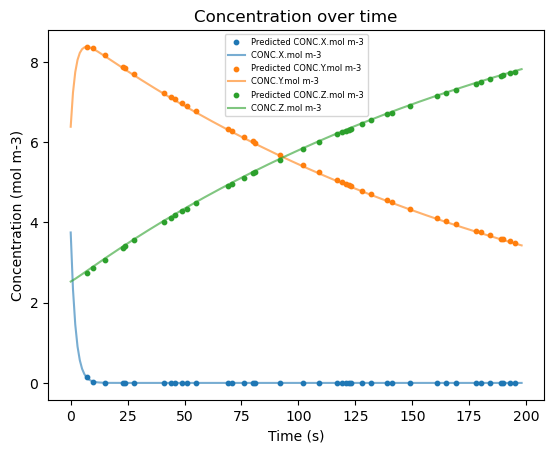

In [9]:
plt.scatter(df.index.tolist(), conc_pred['Predicted CONC.X.mol m-3'], label='Predicted CONC.X.mol m-3', s=10)
plt.plot(df['time.s'], df['CONC.X.mol m-3'], label='CONC.X.mol m-3', alpha=0.6)
plt.scatter(df.index.tolist(), conc_pred['Predicted CONC.Y.mol m-3'], label='Predicted CONC.Y.mol m-3', s=10)
plt.plot(df['time.s'], df['CONC.Y.mol m-3 t+1'], label='CONC.Y.mol m-3', alpha=0.6)
plt.scatter(df.index.tolist(), conc_pred['Predicted CONC.Z.mol m-3'], label='Predicted CONC.Z.mol m-3', s=10)
plt.plot(df['time.s'], df['CONC.Z.mol m-3 t+1'], label='CONC.Z.mol m-3', alpha=0.6)
plt.title('Concentration over time')
plt.ylabel('Concentration (mol m-3)')
plt.xlabel('Time (s)')
plt.legend(loc='upper center', fontsize=6)
plt.show()

## 10. Running and Evaluating the Random Forest Model

With the training and testing data already set up, there is not much work to get the random forest model running.</br>
The only new thing here is the addition of the <i>n_estimators</i> argument which defines the number of trees in the model. Feel free to change this number to experiment.</br>
As with the linear regression model, it is fitted based on the training data, ran on the testing data, and then evaluated against the ground truth.

In [10]:
# Train on training set
model = RandomForestRegressor(n_estimators=100)
model.fit(x_train_scaled_df, y_train_scaled_df)

y_pred = model.predict(x_test_scaled_df)
test_mse = root_mean_squared_error(y_test_scaled_df, y_pred)
print(f"Test RMSE: {test_mse}")

r2 = r2_score(y_test_scaled_df, y_pred)
print(f"Coefficient of determination: {r2}")

Test RMSE: 0.0025146333500230427
Coefficient of determination: 0.9957916540867725


## 11. Data Preparation for Visualization

This step is identical and achieves the same goal as step 8, refer to that step for an explanation.

In [11]:
y_pred = y_scaler.inverse_transform(y_pred)

conc_pred = pd.DataFrame(y_pred, index=y_test.index.tolist(), columns=['Predicted CONC.X.mol m-3', 'Predicted CONC.Y.mol m-3', 'Predicted CONC.Z.mol m-3'])
display(conc_pred)

conc_pred = conc_pred.reindex(df.index)
display(conc_pred)

,Predicted CONC.X.mol m-3,Predicted CONC.Y.mol m-3,Predicted CONC.Z.mol m-3
7,1.410868e-01,8.344051,2.764862
10,3.478943e-02,8.337734,2.877477
15,3.136941e-03,8.169760,3.077103
23,9.211026e-05,7.887283,3.362625
24,3.343374e-05,7.809289,3.440678
28,6.004275e-06,7.679281,3.570713
41,1.455836e-02,7.224764,4.010677
44,3.121510e-09,7.116551,4.133449
46,1.118879e-09,7.048480,4.201520
49,3.130849e-10,6.953162,4.296838


,Predicted CONC.X.mol m-3,Predicted CONC.Y.mol m-3,Predicted CONC.Z.mol m-3
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
194,NaN,NaN,NaN
195,3.637707e-40,3.485506,7.764494
196,NaN,NaN,NaN
197,NaN,NaN,NaN


## 12. Plot the Random Forest Model

This step is identical and achieves the same goal as step 9 but with the random forest model, refer to that step for an explanation.

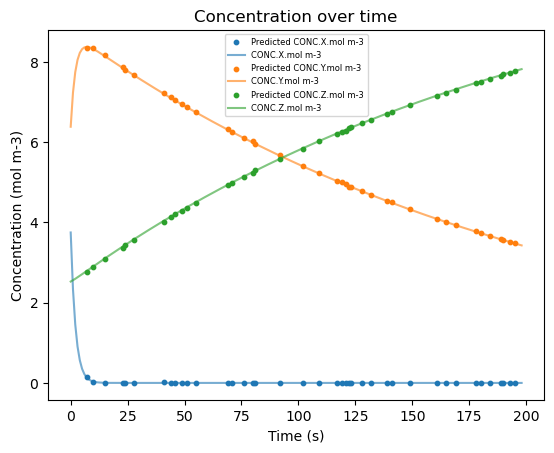

In [12]:
plt.scatter(df.index.tolist(), conc_pred['Predicted CONC.X.mol m-3'], label='Predicted CONC.X.mol m-3', s=10)
plt.plot(df['time.s'], df['CONC.X.mol m-3'], label='CONC.X.mol m-3', alpha=0.6)
plt.scatter(df.index.tolist(), conc_pred['Predicted CONC.Y.mol m-3'], label='Predicted CONC.Y.mol m-3', s=10)
plt.plot(df['time.s'], df['CONC.Y.mol m-3 t+1'], label='CONC.Y.mol m-3', alpha=0.6)
plt.scatter(df.index.tolist(), conc_pred['Predicted CONC.Z.mol m-3'], label='Predicted CONC.Z.mol m-3', s=10)
plt.plot(df['time.s'], df['CONC.Z.mol m-3 t+1'], label='CONC.Z.mol m-3', alpha=0.6)
plt.title('Concentration over time')
plt.ylabel('Concentration (mol m-3)')
plt.xlabel('Time (s)')
plt.legend(loc='upper center', fontsize=6)
plt.show()